# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

In [1]:
# Start coding here...
!pip install hyperopt

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.3 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python3 -m pip install --upgrade pip


## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation

**1. Overview:**

The Head of data Science wants to know whether I can create a binary classification model which predicts with at least 80% of precision in the positive target class --High Popular receipts. Moreover, the Head of Data Science demands that the model minimizes the probability of showing unpopular receipts -- False Positives in the positive class. Thus, our model must have a high precision of at least 80%. I will further elaborate in the lines below, but first. Lets start with the basics!

In [2]:
import numpy  as np
import pandas as pd
import missingno as msno
import re
#++++++++++++++++++
import seaborn as sns
import matplotlib.pyplot as plt
#++++++++++++++++++
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
#++++++++++++++++++
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
#++++++++++++++++++
from sklearn.experimental    import enable_iterative_imputer
from sklearn.impute          import IterativeImputer
from sklearn                 import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing   import MinMaxScaler
from sklearn.metrics         import roc_curve, roc_auc_score
import xgboost as xgb
from sklearn.tree         import DecisionTreeClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.naive_bayes  import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm          import LinearSVC
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.metrics      import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
#++++++++++++++++++++
#++++++++++++++++++++
from hyperopt import fmin, tpe, hp
#++++++++++++++++++++
PATH='https://s3.amazonaws.com/talent-assets.datacamp.com/recipe_site_traffic_2212.csv'
R_STATE = 123

**2. Data Cleaning**

   While importing the dataframe, it is worth noticing:
-    The existence of Missing values
-    category     shall be defined as category_type
-    servings     shall be converted to int
-    high_traffic shall be converted to int (binarize the target feature)


In [3]:
df_raw = pd.read_csv(PATH)
df_raw.shape
display(df_raw.describe())
display(df_raw.info())

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


None

The servings feature must be cleaned before casting it to int to avoid errors. In doing so, we use a regex with a string function

In [4]:
#Create a new df to standarize
df_std1 = df_raw.copy()
#servings treatment :: extract only digits
print('Before Treatment::')
display(df_std1.servings.unique())
df_std1['servings'] = df_std1['servings'].apply(lambda x: re.split(r'\D+', x)[0])
print('After Treatment::')
display(df_std1['servings'].unique())

Before Treatment::


array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

After Treatment::


array(['6', '4', '1', '2'], dtype=object)

**Feature selection for "recipe" feature**

recipe is an id identifier thus it must be deleted since it adds no real features

In [5]:
#feature selection
n_recipe_features = len(df_std1.recipe.unique())
print(f'The number of unique recipe features is: {n_recipe_features}')
#delete feature
df_std2 = df_std1.drop('recipe', axis =1)

The number of unique recipe features is: 947


**NAN treatment Overview**

The msno matrix will provide a visual aid to understand the pattern of the nan data

calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

<AxesSubplot: >

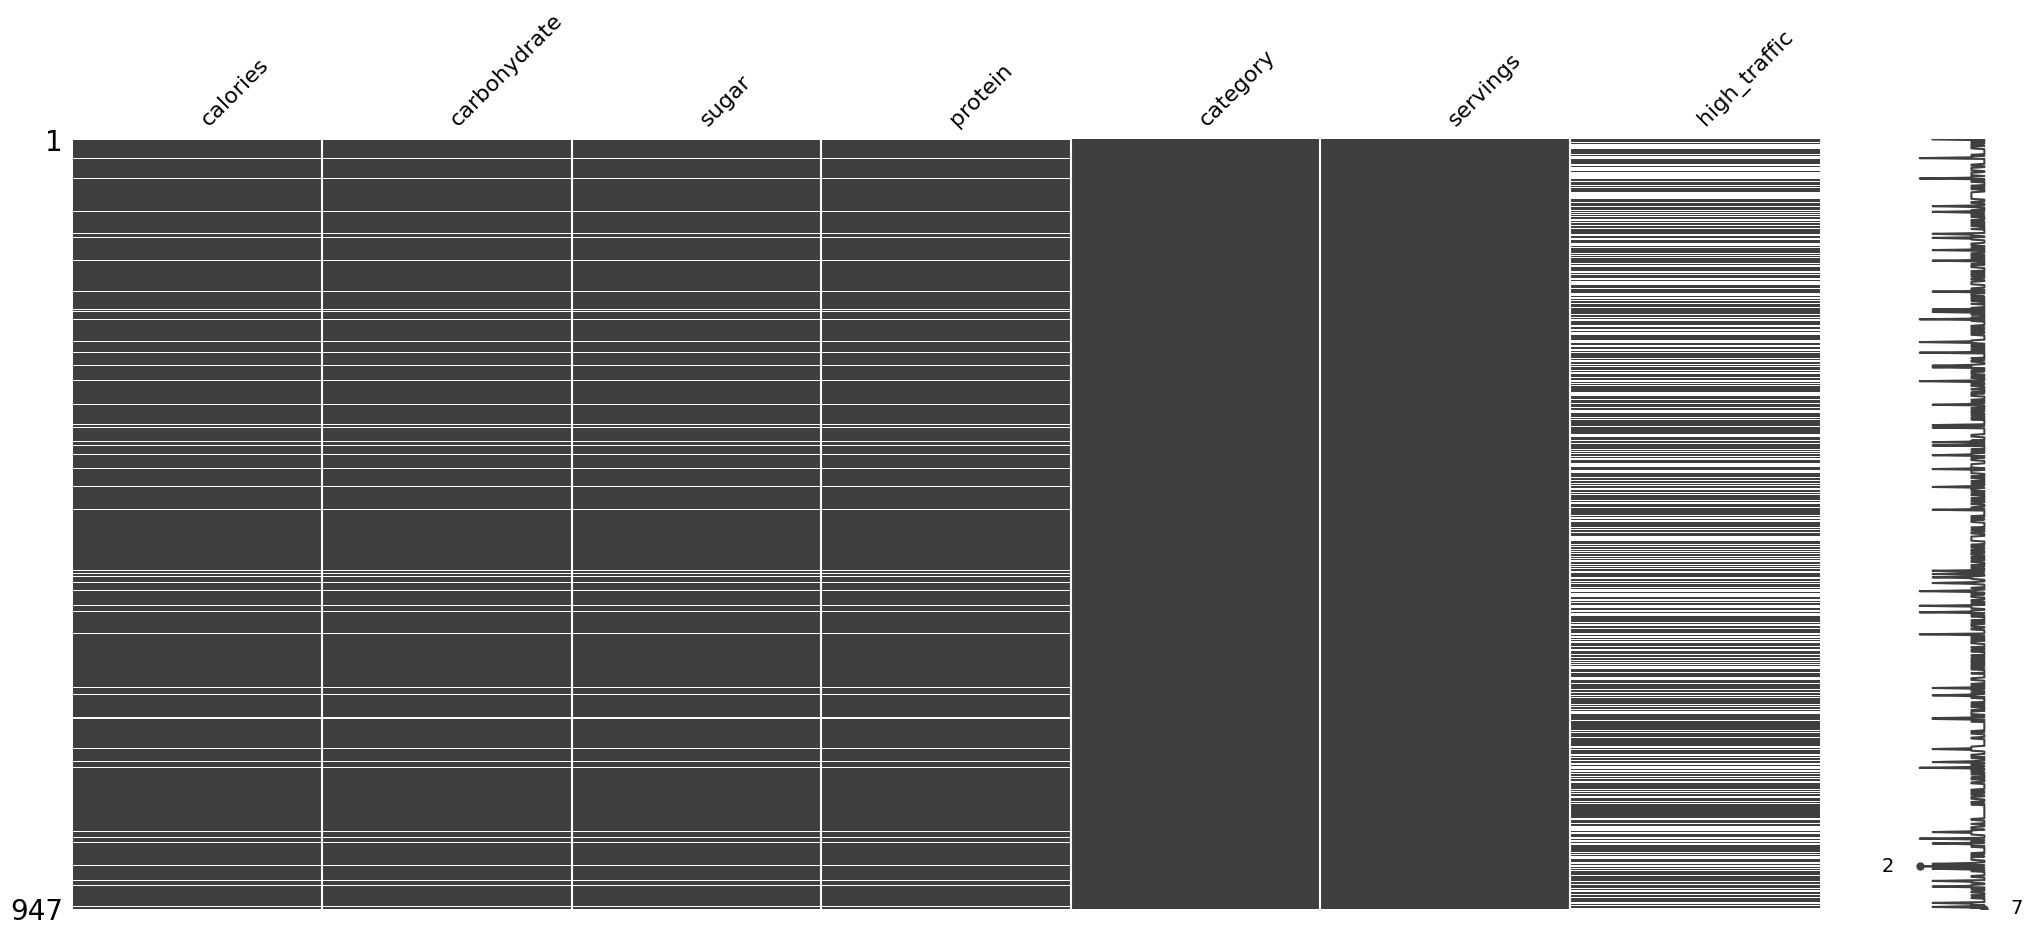

In [6]:
display(df_std2.isna().sum())
msno.matrix(df_std2)

In [7]:
#1. Identify randon pattern
df_nan =df_std2[(df_std2.calories.isna()==1) & (df_std2.carbohydrate.isna() ==1) & (df_std2.sugar.isna() ==1) & (df_std2.protein.isna() == 1)]
display(df_nan.head())
print('Percentage of nan values in dataset: {:.3f} %'.format(100*df_nan.shape[0]/df_std2.shape[0]))

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,NaN,NaN,NaN,NaN,Pork,6,High
23,NaN,NaN,NaN,NaN,Meat,2,NaN
48,NaN,NaN,NaN,NaN,Chicken Breast,4,NaN
82,NaN,NaN,NaN,NaN,Meat,4,High
89,NaN,NaN,NaN,NaN,Pork,6,High


Percentage of nan values in dataset: 5.491 %


Based on the MSO matrix we conclude:
- We have 52 (5.49%) real NAN values for cols 1,2,3,4 (identical pattern) --> Missing not at Random
- We can update the target variable 'high_traffic' to get rid of the nans --> {1: High , 0 :  ~High}

**Updating high_traffic feature**

In [8]:
 # NAN Treatment detail ::update "high_traffic" feature {1: High , 0 :  ~High}
 print('high_traffic values before update: {}'.format(df_std2['high_traffic'].unique()))
 df_std2['high_traffic'] = df_std2['high_traffic'].apply(lambda e: 1 if (e =='High') else 0)
 print('high_traffic values after update: {}'.format(df_std2['high_traffic'].unique()))

high_traffic values before update: ['High' nan]
high_traffic values after update: [1 0]


**Updating the dtypes to normalize the dataframe and improve query performance**

**Analyzing category feature: **

Its's a category type!!!

In [9]:
print(np.array(df_std2['category'].unique()))
print('Number of unique values:',df_std2['category'].unique().shape[0])

['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']
Number of unique values: 11


In [10]:
#Dtypes Treatment
df_std2['servings'] =      df_std2['servings'].astype('int32')
df_std2['category'] =      df_std2['category'].astype('category')
df_std2['high_traffic'] =  df_std2['high_traffic'].astype('category')
display(df_std2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   calories      895 non-null    float64 
 1   carbohydrate  895 non-null    float64 
 2   sugar         895 non-null    float64 
 3   protein       895 non-null    float64 
 4   category      947 non-null    category
 5   servings      947 non-null    int32   
 6   high_traffic  947 non-null    category
dtypes: category(2), float64(4), int32(1)
memory usage: 35.8 KB


None

**Encoding categorical features and imputing the NAN values**

Encoding the category feature for future data modeling. 

Regarding the nan values, since the nan follow a specific pattern, there is an underlying reason for its pattern. I decided not to drop the MNAR values since it migh generate bias. On the contray, I provide a synthetic approach to impute those nan values. (Iterative Imputer). 

In [11]:
# Category feature encode::
df_std3 = pd.get_dummies(pd.get_dummies(df_std2.drop('high_traffic', axis = 1)))
display(df_std3.head())
#*****************************
# Nan Imputation: IterativeImputer
# Since some features have outliers, we use "median" as the intial strategy.
#*****************************
imp_median = IterativeImputer(random_state     =  R_STATE , 
                              initial_strategy = 'median'
                             )

df_std3_X = pd.DataFrame(imp_median.fit_transform (df_std3), columns = df_std3.columns)
df_std3_y = df_std2['high_traffic']

# Concat DataFrame
df_std4 = pd.concat([df_std3_X, df_std3_y], axis = 1)
display(df_std4.head())
#Verify no NAN values:
n_nan = df_std4.isna().sum().sum()

print ('Number of nan values after IterativeImputer: {}'.format(n_nan))
print ('We finally obliterated the nan values!!!')

,calories,carbohydrate,sugar,protein,servings,category_Beverages,category_Breakfast,category_Chicken,category_Chicken Breast,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable
0,NaN,NaN,NaN,NaN,6,0,0,0,0,0,0,0,0,1,0,0
1,35.48,38.56,0.66,0.92,4,0,0,0,0,0,0,0,0,0,1,0
2,914.28,42.68,3.09,2.88,1,0,1,0,0,0,0,0,0,0,0,0
3,97.03,30.56,38.63,0.02,4,1,0,0,0,0,0,0,0,0,0,0
4,27.05,1.85,0.80,0.53,4,1,0,0,0,0,0,0,0,0,0,0


,calories,carbohydrate,sugar,protein,servings,category_Beverages,category_Breakfast,category_Chicken,category_Chicken Breast,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable,high_traffic
0,471.905586,35.021139,8.054799,42.015053,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,35.480000,38.560000,0.660000,0.920000,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,914.280000,42.680000,3.090000,2.880000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,97.030000,30.560000,38.630000,0.020000,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,27.050000,1.850000,0.800000,0.530000,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Number of nan values after IterativeImputer: 0
We finally obliterated the nan values!!!


**Manage Outliers**

No outlier deletion strategy will proceed since it might create a biased model. Moreover, we do not have proof whether those ouliers are data errors. Still, we will identify those outliers using a Z-score >3*std approach.

In [12]:
#Numeric features in the DatFrame
std_cols = ['calories', 'carbohydrate', 'sugar', 'protein', 'servings']
m, s, index_list =[], [], []
df_index  = df_std4.index

for i,j in enumerate(std_cols):
    m = np.mean(df_std4[j])
    s = np.std(df_std4[j])
    index_list.extend(df_index[np.abs((df_std4[j] - m) / s)>3])    
    
#set(index_list)
n_outliers = len(set(index_list))
print('The identified outliers are {} records or {:.2f} % of the current dataframe'.format(n_outliers, (n_outliers/df_std4.shape[0])*100))

The identified outliers are 72 records or 7.60 % of the current dataframe


We conclude that based on the Z_score rule, we have 72 outliers or 7.6% of the dataframe. **Based on the former, we will not proceed to delete those records

**3. EDA (Exploratory Data Analysis)**

The graphic shows no strong correlation between the target and feature variables. I can infer that the target and feature variables are independent!. Moreover, the correlation matrix analysis will bolster this statement later. 


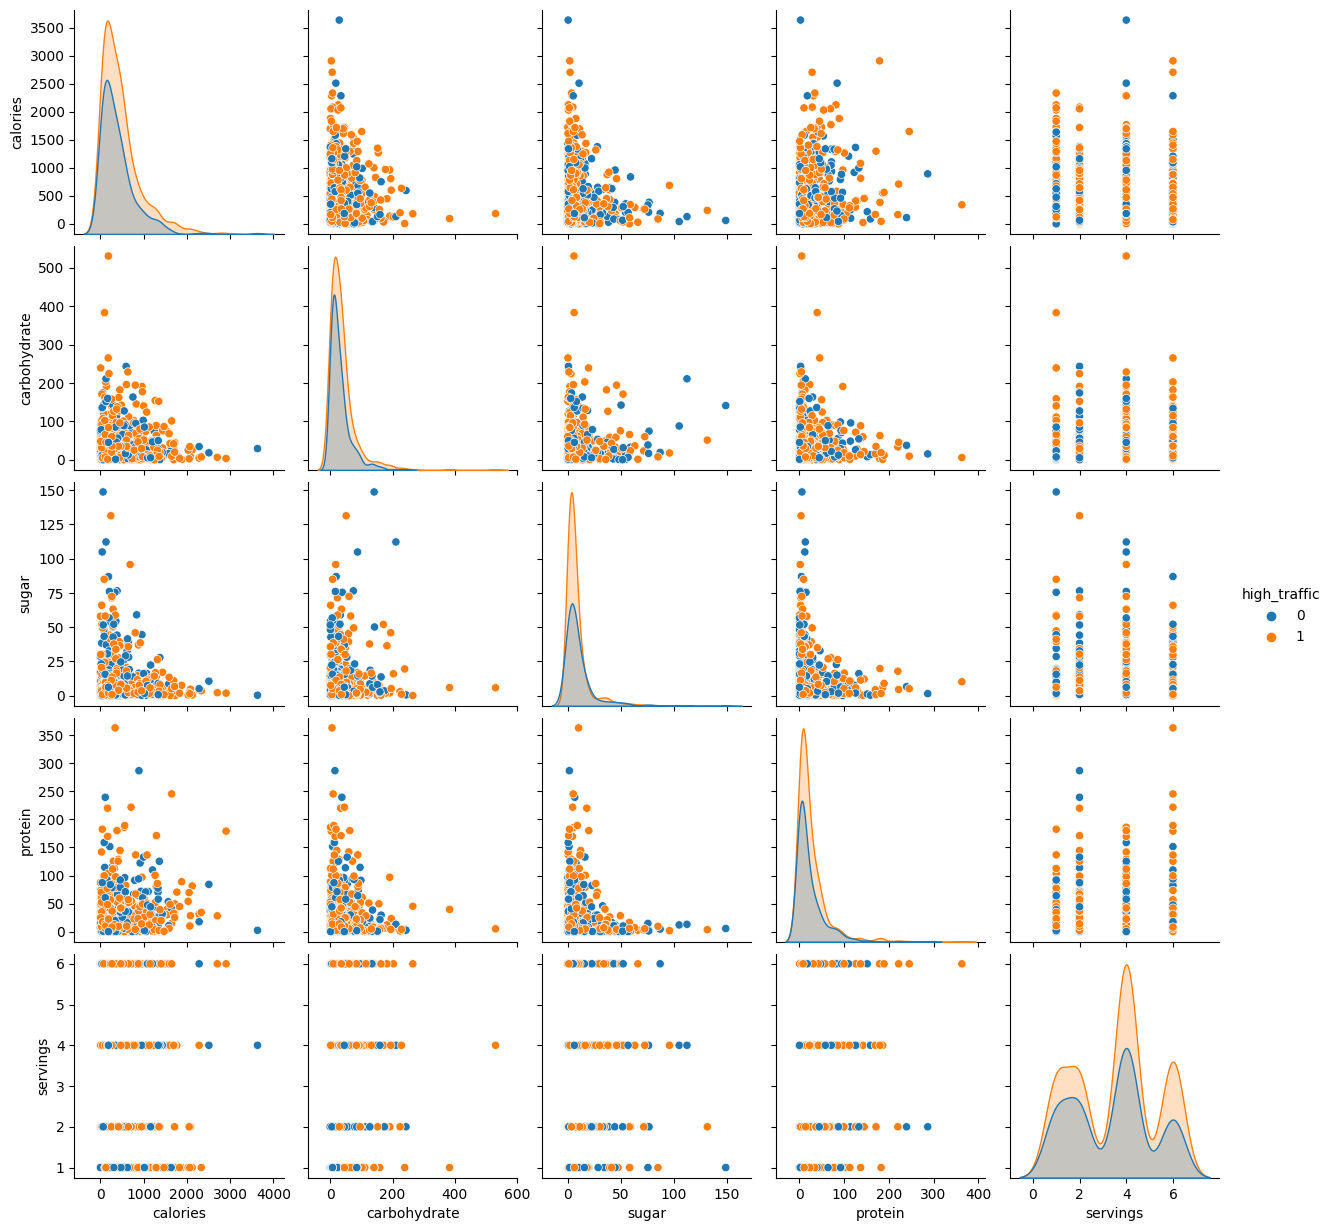

In [13]:
#************
std_cols = ['calories', 'carbohydrate', 'sugar', 'protein', 'servings']
#display(std_cols +['high_traffic']) 
sns.pairplot(df_std4[std_cols +['high_traffic']], hue = 'high_traffic')
plt.show()
#************

**Analyze feature variable distribution**

This analysis is paramount for the model development. In the chart below, for each variable we plot a density distribution, a box plot to analyze the outliers, and a probability plot. 
I conclude that the features follow a non gaussian distribution!
Furthermore, at least the first three features have outliers (the left skewed distributions)!

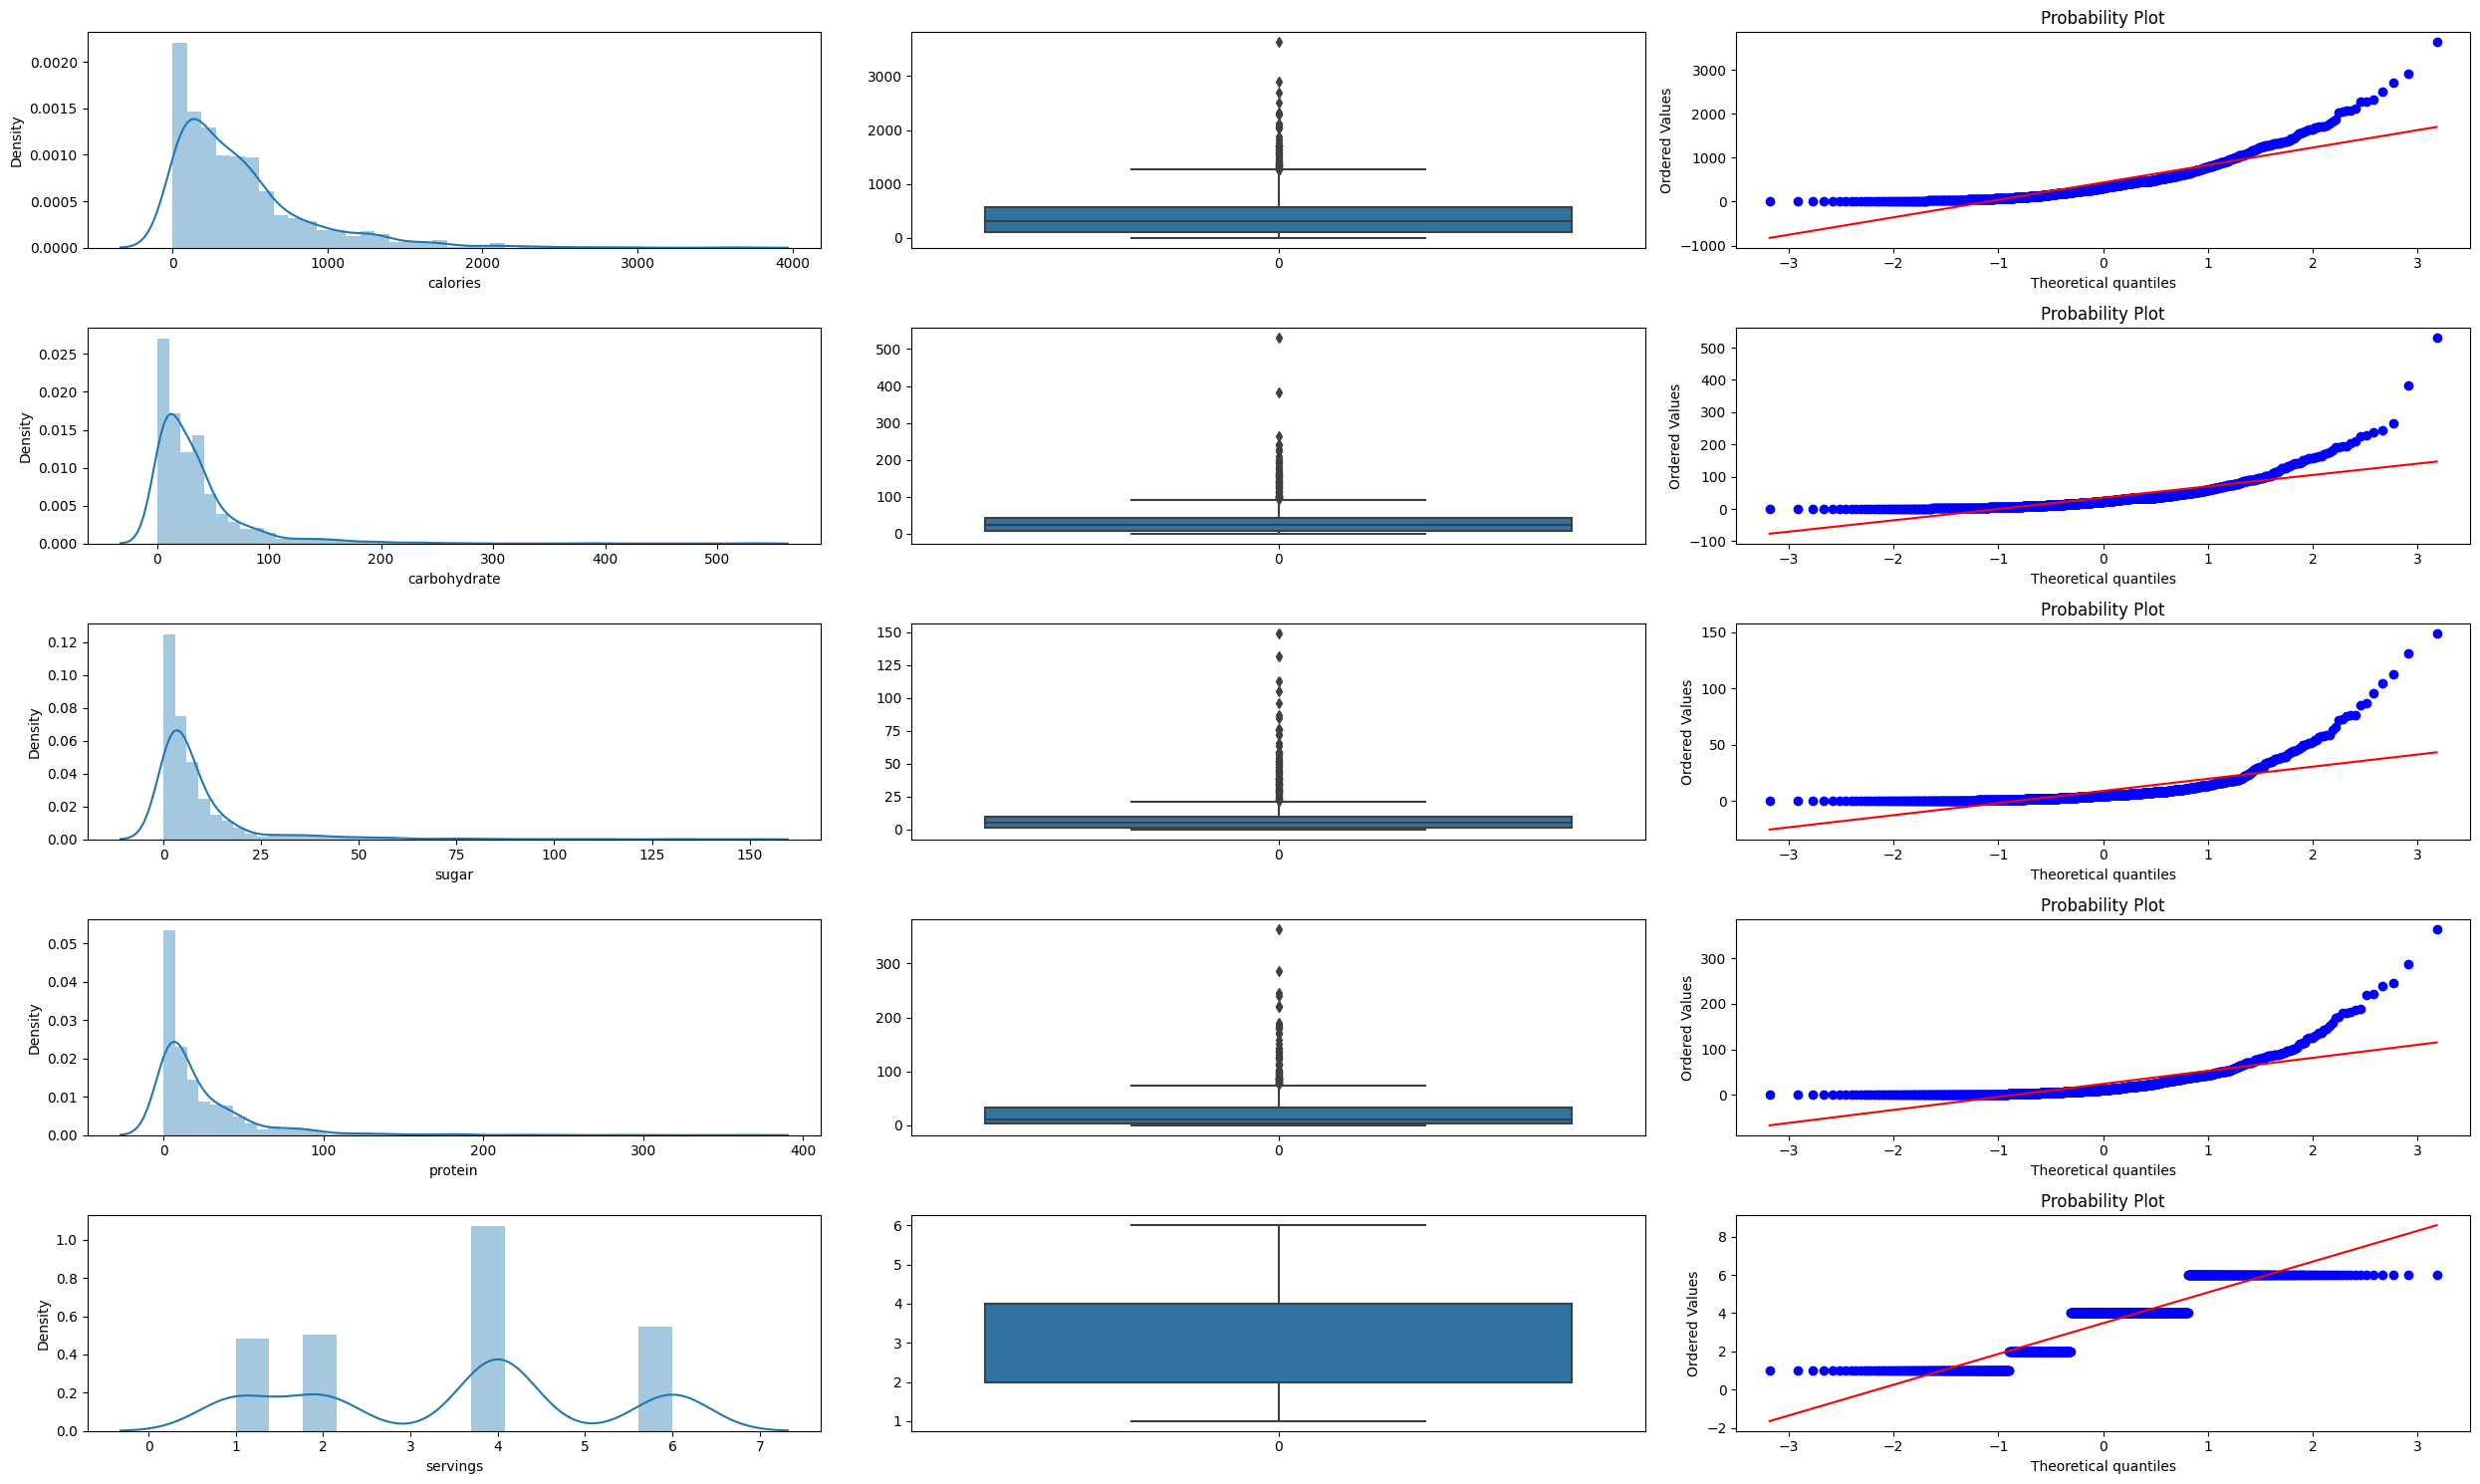

In [14]:
#Analyze feature var distribution

def graph_dataframe( df=None):
    fig, ax = plt.subplots(df.shape[1], 3, figsize=(25, 15))
    for index, i in enumerate(df):
        sns.distplot(df[i],ax = ax[index, 0])
        sns.boxplot(df[i] ,ax = ax[index, 1])
        stats.probplot(df[i],plot = ax[index, 2])
    fig.tight_layout()    

graph_dataframe(df_std4[std_cols])    
#We conclude that the features follow a non gaussian distribution!

**Correlation Matrix Analysis**

Since we demonstrated a non gaussian distribution, we use the spearman method rather than the gaussian's.
The graph proves there is a weak correlation amongst the features, **which rules out colinearity** and therefore supports the model!

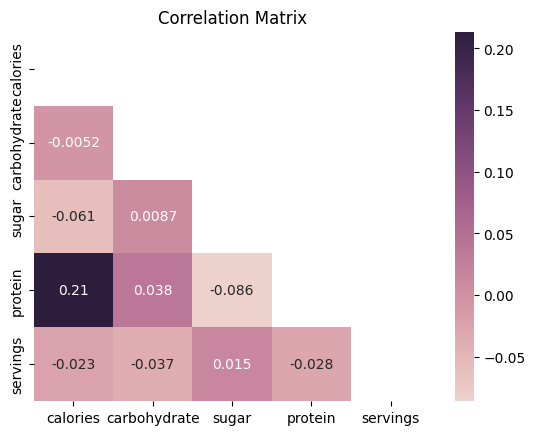

In [15]:
sns.heatmap(df_std4[std_cols].corr(method='spearman'), 
            cmap=sns.cubehelix_palette(as_cmap=True),
            mask=np.triu(np.ones_like(df_std4[std_cols].corr(method='spearman'))),
            annot=True
            )
plt.title('Correlation Matrix')
plt.show()

**Target Class Management::Over Sampling**

Target class is inbalanced (60.6% - 39.4%).
Since the features follow an skewed distribution, overall, over sampling is a reasonable approach to balance the target class


In [16]:
display(df_std4['high_traffic'].value_counts(normalize=True))


ros = RandomOverSampler(random_state=R_STATE)
X_ros, y_ros = ros.fit_resample(df_std4.drop('high_traffic' , axis = 1), df_std4['high_traffic'])

print('Original dataset shape:', Counter(df_std4['high_traffic']))
print('Resample dataset shape:', Counter(y_ros))

display(y_ros.value_counts(normalize=True))

1    0.606125
0    0.393875
Name: high_traffic, dtype: float64

Original dataset shape: Counter({1: 574, 0: 373})
Resample dataset shape: Counter({1: 574, 0: 574})


0    0.5
1    0.5
Name: high_traffic, dtype: float64

**4. Scaling Features**

In order to prepare the data for Data modeling, we need to scale the data and split it into the training and testing set.
StandardScaler is not suitable because the feature follows a non gaussian distribution. Instead, we use a MinMaxScaler! 


In [31]:
#Split
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.25, random_state=R_STATE)
#***********
m2scaler = MinMaxScaler()
X_train = m2scaler.fit_transform(X_train)
X_test  = m2scaler.transform(X_test)


**5. Data Modeling**

We ran the most common models for classification in their basal state and test accuracy to select the best prospects

In [18]:
#Modeling Data

model_list, model_accuracy, model_precision, model_recall  = {}, {}, {}, {} 

model_list['XGBClassifier']          = xgb.XGBClassifier( random_state = R_STATE,   
                                                      max_depth=80,
                                                      n_estimators=700,
                                                    )
model_list['DecisionTreeClassifier'] = DecisionTreeClassifier(random_state = R_STATE)
model_list['RandomForestClassifier'] = RandomForestClassifier(random_state = R_STATE)
model_list['LogisticRegression']     = LogisticRegression(random_state = R_STATE)
model_list['LinearSVC']              = LinearSVC(random_state = R_STATE)
model_list['KNeighborsClassifier']   = KNeighborsClassifier()

for j in model_list.keys():
    model_list[j].fit(X_train, y_train)
    model_accuracy[j]  = accuracy_score(y_test, model_list[j].predict(X_test))
    model_precision[j] = precision_score(y_test, model_list[j].predict(X_test))
    model_recall[j]    = recall_score(y_test, model_list[j].predict(X_test))

df_model_score = pd.DataFrame(index = model_list.keys(), 
                              data = {'accuracy': model_accuracy, 'precision': model_precision, 'recall': model_recall}
                             )
df_model_score.sort_values('precision', ascending=False)


,accuracy,precision,recall
RandomForestClassifier,0.787456,0.761290,0.830986
LogisticRegression,0.783972,0.750000,0.845070
LinearSVC,0.780488,0.748428,0.838028
DecisionTreeClassifier,0.745645,0.737931,0.753521
XGBClassifier,0.749129,0.730263,0.781690
KNeighborsClassifier,0.710801,0.703448,0.718310


**6. Selecting Pospect Models**

Since my key customer - the Head of Data Science - demands high precision in the positive class (at least 80%). Based on the former table with models and their metrics, we choose the RandomForestClassifier and XGBClassifier since their precision ratio are the highest.

In the confusion Matrix:

Precision = TP/(TP + FP), in which FP are the False Positive and TP are the True Positives. The idea is to minimize showing unpopular receipts as if they were populars (False Positives). In the former equation is FP is minimized, then the Precision record is maximized.

Based on our first model estimation, we further elaborate by plotting the model performance in a range of different scenarios (cross validation data splits). Furthermore, since the original dataframe had a target imbalanced class, I use the StratifiedKFold for cross valitation techniques.

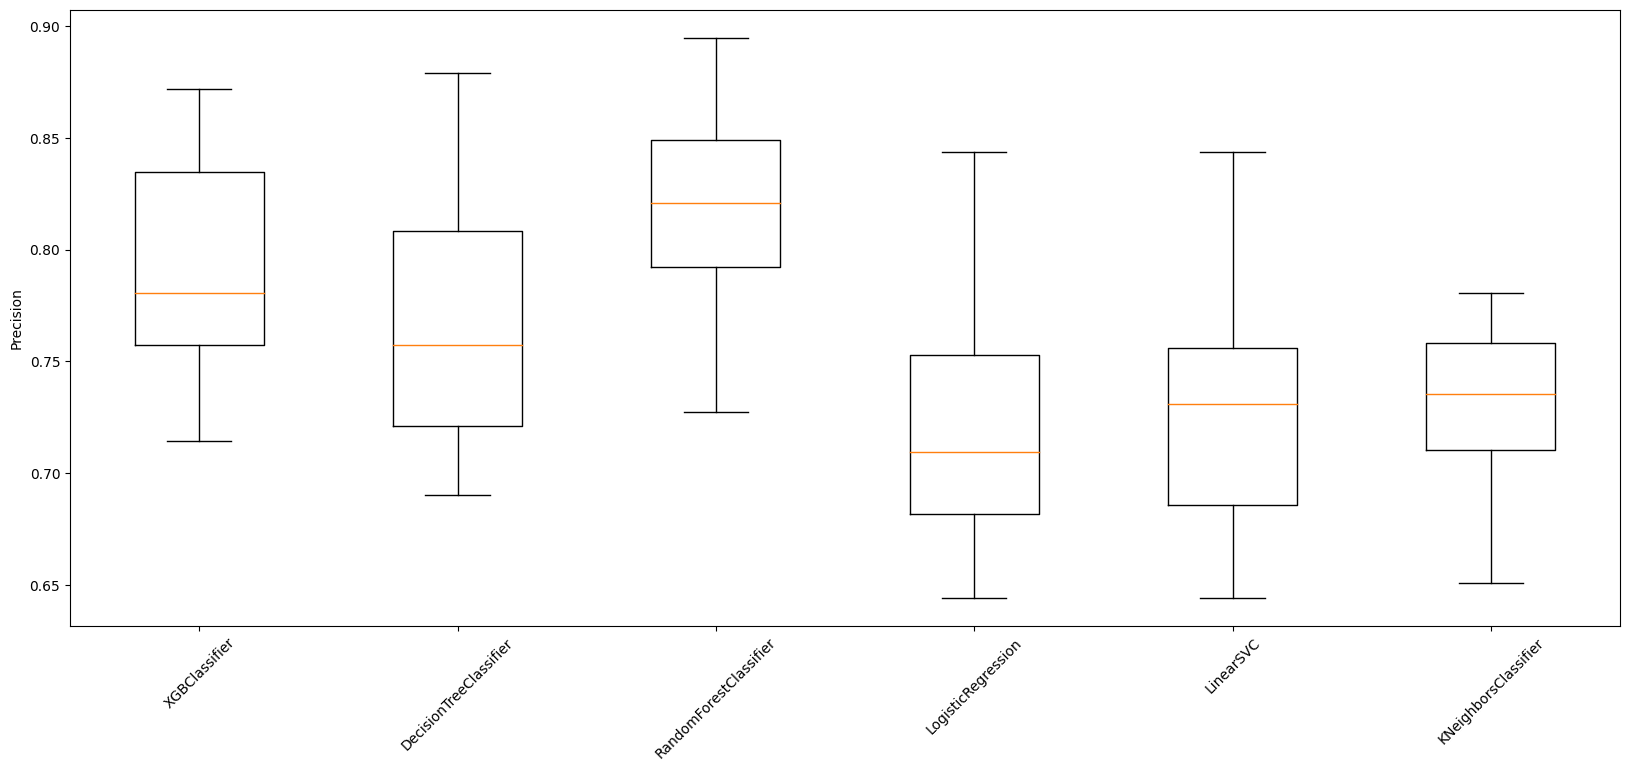

In [19]:
results = []

for model in model_list.values():     
    kf = StratifiedKFold(n_splits=10, 
                         random_state=R_STATE, 
                         shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring='precision')
    results.append(cv_results)
    
# Ploting a boxplot comparison between models
plt.figure(figsize=(20,8))
plt.boxplot(results, labels=model_list.keys())
plt.xticks(rotation=45)
plt.ylabel('Precision')
plt.show()

The graph above bolsters our initial theory that XGBClassifier and RandomForestclassifier are the best models.


**7. Optimizing the XGBClassifier**

Due to the computational constraints, a bayesian approach is a reasonable course of action. Thus, we use the hyperopt library to tune the key parameters of the estimator. We also define the target function as the accuracy of the testing set. In doing so, we obtain a precision score of 83.48% which complies with the 80% target.

In [20]:
space = {
            'learning_rate'    :  hp.uniform('learning_rate', 0.8, 0.9),                
            'alpha'            :  hp.quniform('alpha',54, 55, 1), 
            'n_estimators'     :  hp.quniform('n_estimators', 760, 770, 10),   
            'max_depth'        :  hp.quniform('max_depth', 440, 450, 10),            
            'subsample'        :  hp.uniform('subsample', 0.7, 0.9),
            'colsample_bytree' :  hp.uniform('colsample_bytree', 0.8, 0.9),
            'gamma'            :  hp.uniform('gamma', 0.5, 0.6),
            
        }
def target_function(params):
    
    params = {
                'learning_rate'    :  params['learning_rate'],
                'alpha'            :  int(params['alpha']), 
                'n_estimators'     :  int(params['n_estimators']),   
                'max_depth'        :  int(params['max_depth']),            
                'subsample'        :  params['subsample'],
                'colsample_bytree' :  params['colsample_bytree'],
                'gamma'            :  params['gamma'],                
             }
    gbm_clf = xgb.XGBClassifier(
                                random_state=R_STATE,
                                objective   ='reg:logistic',
                                booster     ='gbtree',
                                **params
                                )
    gbm_clf.fit(X_train, y_train)
    #sometimes less is more :)
    loss = - precision_score(y_test, gbm_clf.predict(X_test))    
    return loss

best_result = fmin(
                   fn= target_function,
                   space = space,
                   max_evals= 50,
                   rstate = np.random.default_rng(R_STATE),
                   algo = tpe.suggest 
                  ) 

dict_params_est = dict((x,y) for (x,y) in [e for e in best_result.items()]) 
#Updating formats of integer fields
#**************
dict_params_est['alpha']        = int(dict_params_est['alpha']) 
dict_params_est['n_estimators'] = int(dict_params_est['n_estimators'])   
dict_params_est['max_depth']    = int(dict_params_est['max_depth'])   
#**************
print(dict_params_est)

100%|██████████| 50/50 [00:54<00:00,  1.08s/trial, best loss: -0.8348623853211009]
{'alpha': 55, 'colsample_bytree': 0.8199003197443605, 'gamma': 0.5497561066282863, 'learning_rate': 0.8462000184517513, 'max_depth': 450, 'n_estimators': 770, 'subsample': 0.8005235648707549}


**8. Analyzing the classification report**

The optimal parameters are saved in the gbm_clf. I will proceed to calculate all the metrics. Let's analyze the precision metrics in the classification report:

The False Positive for the High Class is 17% whereas the False Positive for the Not High Class is 29%.
The model is more precise in the "High" class than in the "Non High" class.
- The obtained precision for the positive class is 83.48%, which complies with the business metrics of 80% or more.

Regarding the recall metrics (TP / (TP + FN)):

The False Negative for the High Class is 36% whereas the False Negative for the Non High Class is 12%.
The model has a better recall ratio in the "Non High" class than in the "High" class.
The overall avg recall or sensitivity is 76% for the model which is a decent score.
Overall, the 83.48% model precision complies with the Head of Data Science requirement.

In [21]:
#Updating the best XGBClassifier Model
#*************
gbm_clf = xgb.XGBClassifier(
                                random_state=R_STATE,
                                objective   ='reg:logistic',
                                booster     ='gbtree',
                                **dict_params_est
                                )
gbm_clf.fit(X_train, y_train)
ascore = accuracy_score(y_test, gbm_clf.predict(X_test)) 
#*************
print('XGBClassifier Accuracy:::{}'.format(ascore) )
print(classification_report(y_test, gbm_clf.predict(X_test), target_names=['Non High','High']))
#*************


print('precision', precision_score(y_test, gbm_clf.predict(X_test))) 
print('recall', recall_score(y_test, gbm_clf.predict(X_test)))

XGBClassifier Accuracy:::0.759581881533101
              precision    recall  f1-score   support

    Non High       0.71      0.88      0.79       145
        High       0.83      0.64      0.73       142

    accuracy                           0.76       287
   macro avg       0.77      0.76      0.76       287
weighted avg       0.77      0.76      0.76       287

precision 0.8348623853211009
recall 0.6408450704225352


**8.1 Confusion Matrix**

For this XGBoostingClassifier, the confusion matrix is generated

In [22]:
conf_matrix = confusion_matrix(y_test, gbm_clf.predict(X_test))
display(conf_matrix)

array([[127,  18],
       [ 51,  91]])

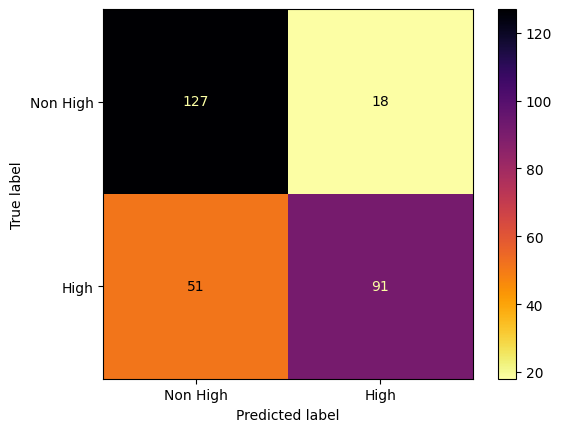

In [23]:
disp_cm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                 display_labels  =['Non High', 'High']
                                )
# Plot the confusion matrix
disp_cm.plot(cmap='inferno_r')

In [24]:
tn, fp, fn, tp = conf_matrix.ravel()
saux = """
True Negatives: {0}
False Positives: {1}
False Negatives: {2}
True Positives: {3}
""".format(tn, fp, fn, tp)
print(saux)


True Negatives: 127
False Positives: 18
False Negatives: 51
True Positives: 91



**9. Feature Importances (Gini Index)**

Based on the Gini Index, we can ascertain that the categories Potato, Chicken and Chicken Breast have considerable importance in this model.

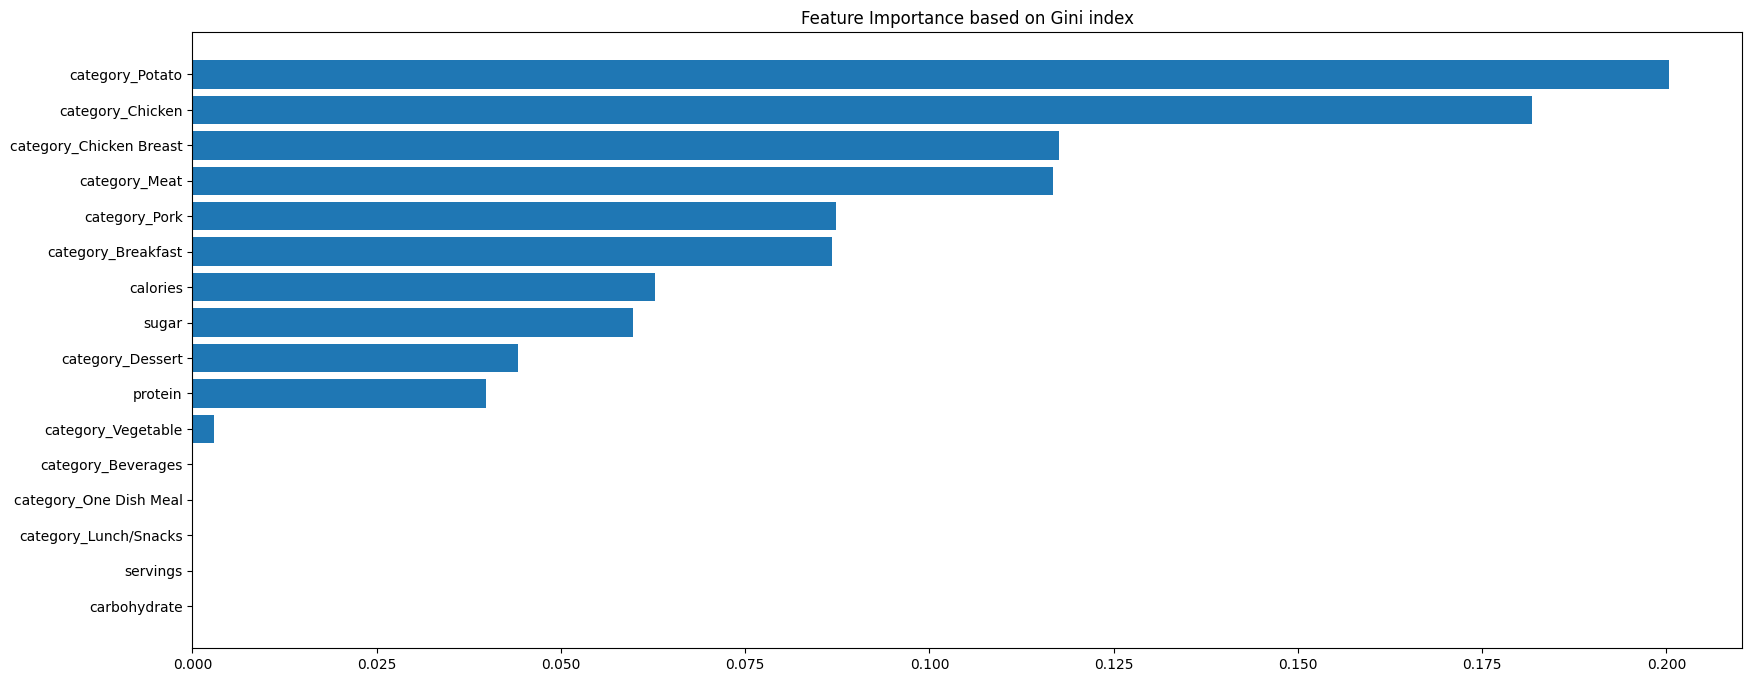

In [25]:
feat_imp = gbm_clf.feature_importances_
#Creating an index sorting feature importance values
sorted_indx = np.argsort(feat_imp)
#X_ros.colums has the same column structure as X_test (np.array)
fig = plt.figure(figsize = (20,8))
plt.barh( range(len(feat_imp)) ,
          feat_imp[sorted_indx],
          align ='center'
        )
plt.yticks(range(len(feat_imp)), 
           X_ros.columns[sorted_indx]     
          )
plt.title('Feature Importance based on Gini index')
plt.show()

**10. ROC AUC :::The best suitable performance indicator**

In a classification problem the ROC AUC Score is the most reliable metric since it takes in consideration the true positive rate and false positive rate. The 82.82% roc_auc score means that this model has a high ability to distinguish between the positive and negative class. Indeed, the model is almost 65.64% better than a chance model --or random guessing -- at correctly predicting the classes.

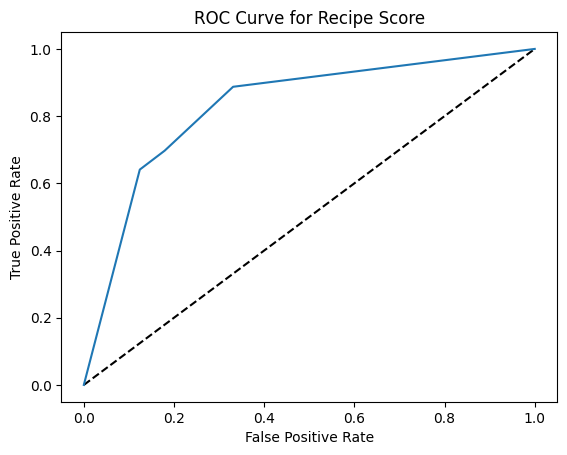

score_roc_accuracy 0.828169014084507


In [26]:
y_pred_probs = gbm_clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.plot([0, 1], [0, 1], 'k--')

# Plot ROC Curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Recipe Score')
plt.show()
print('score_roc_accuracy', roc_auc_score(y_test, gbm_clf.predict_proba(X_test)[:,1]) )

**Sensitivity (Recall) and Specificity**

Sensitivity : The proportion of getting a High recipe (positive class) and it gets correctly classified is 64.08%! 

Specificity: The proportion of getting a Non High (negative class) and it gets correctly classified is 87.59%!

In [27]:
def metrics(tn, fp, fn, tp):
    sen = tp / (tp + fn)
    print("Sensitivity: {0}".format(sen*100))
    spe = tn / (tn + fp)
    print("Specificity: {0}".format(spe*100))

metrics(tn, fp, fn, tp)

Sensitivity: 64.08450704225352
Specificity: 87.58620689655172


**11. Optimizing the RandomForestClassifier::Alternative Approach**

Due to the computational constraints, a bayesian approach is a reasonable course of action. Thus, we use the hyperopt library to tune the key parameters of the RF estimator. We also define the target function as the precision of the testing set. In doing so, we obtain an accuracy score of 79.47% which does not comply with the 80% target.

In [28]:
space = {
          'n_estimators'     : hp.quniform('n_estimators', 80, 290, 10),
          'max_depth'        : hp.quniform('max_depth', 340, 360, 1), 
          'min_samples_split': hp.quniform('min_samples_split', 10, 30, 1),
          'min_samples_leaf' : hp.quniform('min_samples_leaf', 1, 30, 1)
        }

def target_function(params):
    
    params = {
                'n_estimators'      :  int(params['n_estimators']),
                'max_depth'         :  int(params['max_depth']),
                'min_samples_split' :  int(params['min_samples_split']),
                'min_samples_leaf'  :  int(params['min_samples_leaf'])
             }
    
    rf_clf = RandomForestClassifier(random_state=R_STATE, **params)
    rf_clf.fit(X_train, y_train)
    loss = - precision_score(y_test, rf_clf.predict(X_test))    
    return loss
    

best_result = fmin(
                   fn= target_function,
                   space = space,
                   max_evals= 50,
                   rstate = np.random.default_rng(R_STATE),
                   algo = tpe.suggest 
                  )


dict_params_est = dict((x,y) for (x,y) in [e for e in best_result.items()]) 
#Updating formats of integer fields
#**************
dict_params_est['n_estimators']      = int(dict_params_est['n_estimators'])   
dict_params_est['max_depth']         = int(dict_params_est['max_depth'])   
dict_params_est['min_samples_split'] = int(dict_params_est['min_samples_split'])   
dict_params_est['min_samples_leaf']  = int(dict_params_est['min_samples_leaf'])   
#**************

print(dict_params_est)

100%|██████████| 50/50 [00:12<00:00,  3.99trial/s, best loss: -0.7947019867549668]
{'max_depth': 360, 'min_samples_leaf': 9, 'min_samples_split': 10, 'n_estimators': 110}


**12. RF Classifier ::: Analysis**

Based on the classification report lines below we conclude the following:

The optimal Random Forest classifier (79.47%) is less precise than the optimal XGBoostClassifier (83.48%). In contrast, the sensitivity or recall of the positive class in the XGBoostClassifier(64%) is worse than the Random Forest's (84.50%).

Overall, I chose the XGBoostClassifier since the key business metric is the highest precision to minimize the False Positives in the positive class.

Thus,I will not follow any further analysis on the Random Forest classifier Model.

In [29]:
#Updating the best RF Classifier Model
#*************
rf_clf = RandomForestClassifier(
                                random_state=R_STATE,
                                **dict_params_est
                                )

rf_clf.fit(X_train, y_train)
ascore = accuracy_score(y_test, rf_clf.predict(X_test)) 
#*************
print('RF Accuracy:::{}'.format(ascore) )
print(classification_report(y_test, rf_clf.predict(X_test), target_names=['Not High','High']))
#*************


print('RF precision', precision_score(y_test, rf_clf.predict(X_test))) 
print('RF recall', recall_score(y_test, rf_clf.predict(X_test)))

RF Accuracy:::0.8153310104529616
              precision    recall  f1-score   support

    Not High       0.84      0.79      0.81       145
        High       0.79      0.85      0.82       142

    accuracy                           0.82       287
   macro avg       0.82      0.82      0.82       287
weighted avg       0.82      0.82      0.82       287

RF precision 0.7947019867549668
RF recall 0.8450704225352113


**13. Final thoughts:**

Despite there is a lot of controversy about outliers, I do not remove them since there is no proof that they are noise or statistical errors

Missing Not at Random shall not be deleted despite it comprised a small percentage in our population.

The 83.48% XGBoostClassifier model, meets the requested criteria: best possible precision (greater than 80%) and the minimum False Positives for the positive class.

The ROC AUC metric is the recommended metric for accuracy in a binary classification problem since we focus on the probability of a class precition.

In a business perspective, the web traffic heavily relies on the correct classification of our positive binary class. If the recipe is popular, then web traffic rises and therefore the possibility to get more subscriptions (revenue for Tasty bytes).

As a result. I do believe the current model must focus on the precision metric since an incorrect classification of the High popular receipts (False Positive cases) can hurt customer confidence and might churn customers away or decrease retention ratios. Further investigation can be made with the Outliers and MNAR values to identify whether they are errors (we shall inquiry with the Product Managment Team)

**Recommendations**

We shall analyze a ML Model with high precision but also high recall since it would be great to also minimize the False Negatives in our model. 

Further investigation can be made with the Outliers and MNAR values to identify whether they are errors (we shall inquiry with the Product Management Team) 

Clustering shall be made to evaluate new parameters that might influence in the customer preferences for our website. For instance, what if “price” is a parameter we are overlooking? 

A/B Test shall be performed for the new recipes over time to validate the validity of our model.